<a href="https://colab.research.google.com/github/Bhavani-Shankar-Arugonda/Projects/blob/master/creditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

df=pd.read_csv('creditcard.csv');

print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

missing_values = df.isnull().sum().max()
print(f"\nMax missing values in any column: {missing_values}")

Dataset Shape: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


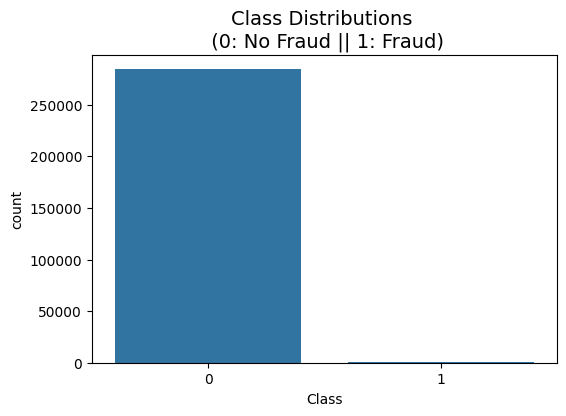


Scaling Complete. First 5 rows of new data:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

# Scale Time and Amount
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Remove the original unscaled columns
df.drop(['Time','Amount'], axis=1, inplace=True)

# Move the scaled columns to the front of the dataset (just for cleanliness)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

print("\nScaling Complete. First 5 rows of new data:")
print(df.head())

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Define X (Features) and y (Target)
X = df.drop('Class', axis=1)  # Everything except the 'Class' column
y = df['Class']               # Only the 'Class' column

# 2. Perform Stratified Split
# test_size=0.2 means 20% of data goes to testing
# stratify=y ensures the 0.17% fraud ratio is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Verification
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

# Check the distribution (Should be roughly equal)
train_percent = y_train.value_counts()[1] / len(y_train) * 100
test_percent = y_test.value_counts()[1] / len(y_test) * 100

print(f"\nFraud % in Train Set: {train_percent:.2f}%")
print(f"Fraud % in Test Set:  {test_percent:.2f}%")

Training Set Shape: (227845, 30)
Test Set Shape: (56962, 30)

Fraud % in Train Set: 0.17%
Fraud % in Test Set:  0.17%


In [ ]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. Apply SMOTE (Only on Training Data!)
# sampling_strategy=0.1 means "Make the minority class 10% the size of the majority class"
print("Applying SMOTE... (This may take a moment)")
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Original Training Shape: {X_train.shape}")
print(f"Resampled Training Shape: {X_train_res.shape}")

# Check the new class distribution
print('Resampled Fraud Count:', y_train_res.value_counts()[1])

# 2. Initialize and Train XGBoost
# scale_pos_weight=10: Even with SMOTE, fraud is still the minority (10%).
# This parameter tells the model: "Treat every fraud mistake as 10x worse than a normal mistake."
model = XGBClassifier(
    n_estimators=100,     # 100 decision trees
    learning_rate=0.1,    # Step size optimization
    max_depth=4,          # Tree depth (prevent overfitting)
    scale_pos_weight=10,  # Penalty for missing fraud
    eval_metric='aucpr',  # Optimize for Precision-Recall Area Under Curve
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

print("\nTraining XGBoost Model...")
model.fit(X_train_res, y_train_res)
print("Model Training Complete!")

Applying SMOTE... (This may take a moment)
Original Training Shape: (227845, 30)
Resampled Training Shape: (250196, 30)
Resampled Fraud Count: 22745

Training XGBoost Model...
Model Training Complete!


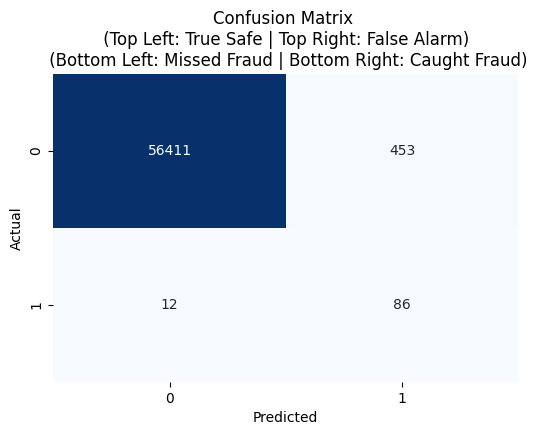


>> PR-AUC Score: 0.7818
(This is the number you put on your resume. Anything above 0.70 is excellent for this dataset)

>> Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.88      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.93      0.63     56962
weighted avg       1.00      0.99      0.99     56962



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

# 1. Make Predictions on the Test Set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of being fraud

# 2. Confusion Matrix
# This tells us exactly where we were right and wrong
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix \n (Top Left: True Safe | Top Right: False Alarm) \n (Bottom Left: Missed Fraud | Bottom Right: Caught Fraud)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. The "Resume Score" (PR-AUC)
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"\n>> PR-AUC Score: {pr_auc:.4f}")
print("(This is the number you put on your resume. Anything above 0.70 is excellent for this dataset)")

# 4. Detailed Report
print("\n>> Classification Report:")
print(classification_report(y_test, y_pred))